In [1]:
import pandas as pd
import numpy as np
import random
import wfdb
import ast
import tensorflow as tf
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

import os
import matplotlib.pyplot as plt

2024-03-28 22:08:43.183534: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 22:08:44.718597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 22:08:44.718625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 22:08:44.878428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 22:08:45.226611: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
# from pathlib import Path
path = "/home/zfenton/my_project/ml_project/path/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100

In [4]:
# load and convert annotation data
# Y = pd.read_csv("/home/zfenton/my_project/ml_project/path/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv", index_col="ecg_id")
Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [5]:
X = load_raw_data(Y, sampling_rate, path)

In [6]:
X.shape

(21799, 1000, 12)

In [ ]:
#record = wfdb.rdrecord(path+'records100/00000/00001_lr', sampto=500)
# wfdb.plot_wfdb(record=record, annotation=Y, title='Record 100 from MIT-BIH Arrhythmia Database')

In [7]:
record = wfdb.rdrecord(path+'records100/00000/00001_lr', sampto=500)
annotation = wfdb.rdann(path+'scp_statements', 'csv', sampto=100, shift_samps=True)

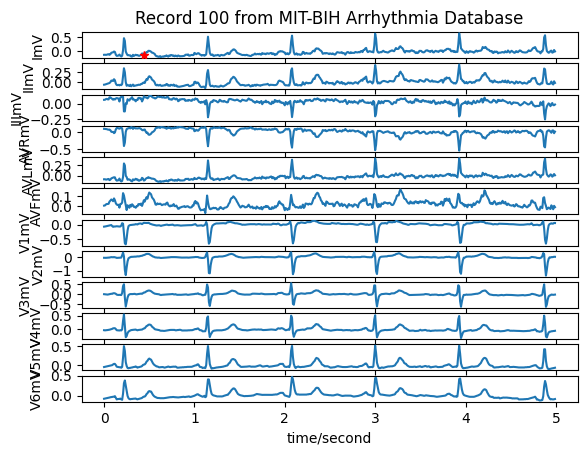

In [8]:
wfdb.plot_wfdb(record=record, annotation=annotation, title='Record 100 from MIT-BIH Arrhythmia Database')

In [9]:
X[1]

array([[ 0.004,  0.138,  0.134, ...,  0.192,  0.083,  0.088],
       [-0.02 ,  0.116,  0.136, ...,  0.156,  0.057,  0.063],
       [-0.053,  0.092,  0.145, ...,  0.107,  0.013,  0.022],
       ...,
       [ 0.121,  0.398,  0.277, ..., -1.065, -0.492, -0.156],
       [-0.326,  0.057,  0.383, ..., -0.28 , -0.175, -0.071],
       [-0.348, -0.056,  0.292, ..., -0.308, -0.231, -0.145]])

In [10]:
agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [11]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [12]:
# Convert labels to be either NORM or ABNORM
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: x[0] if len(x) > 0 else 'NORM')

Y['diagnostic_superclass'].value_counts()

NORM    9925
MI      5438
CD      2715
STTC    2405
HYP     1316
Name: diagnostic_superclass, dtype: int64

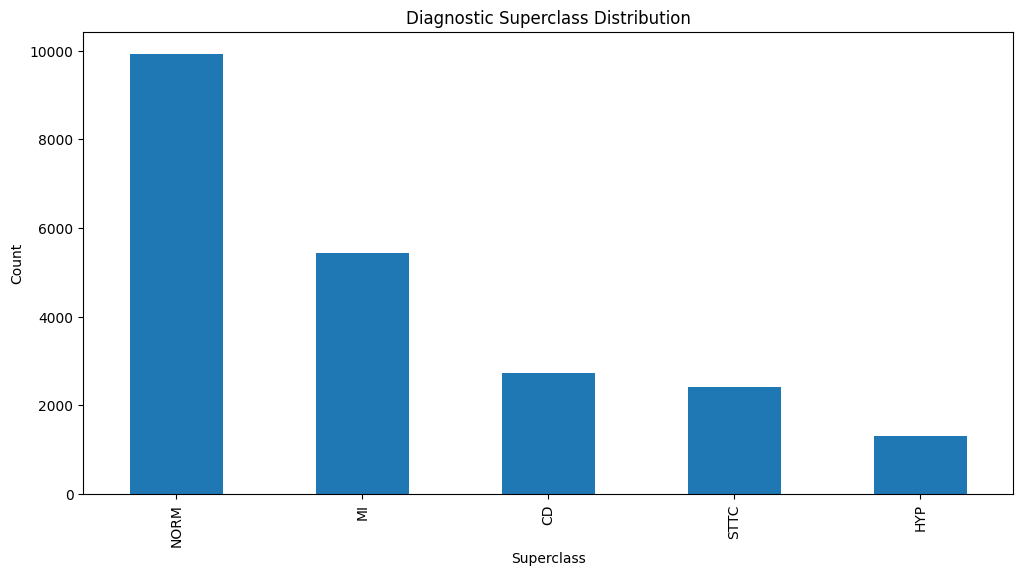

NORM    45.529611
MI      24.946098
CD      12.454700
STTC    11.032616
HYP      6.036974
Name: diagnostic_superclass, dtype: float64


In [17]:
# Plot the distribution of the classes
plt.figure(figsize=(12,6))
Y['diagnostic_superclass'].value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

# Calculate the percentage of each class
print(Y['diagnostic_superclass'].value_counts(normalize=True) * 100)



In [13]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [18]:
y_train.value_counts()

NORM    8922
MI      4893
CD      2437
STTC    2162
HYP     1187
Name: diagnostic_superclass, dtype: int64

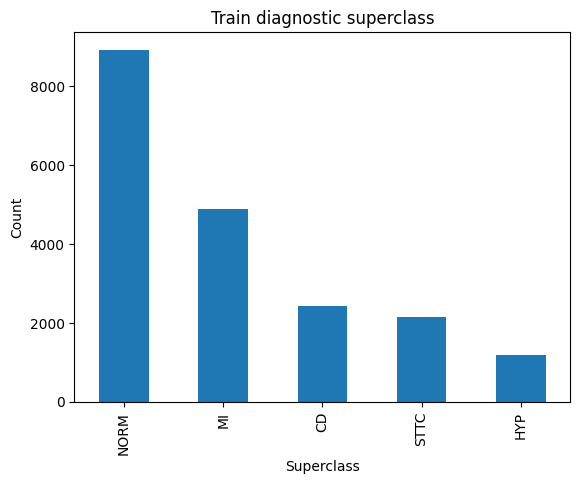

In [19]:
y_train.value_counts().plot(kind='bar')
plt.title("Train diagnostic superclass")
plt.xlabel("Superclass")
plt.ylabel("Count")
plt.show()

In [20]:
# Baseline model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Train the classifier
dummy.fit(X_train, y_train)

# Predict the labels
y_pred = dummy.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")



Accuracy: 45.63%


### Baseline:

A baseline model where we predict that all EKG readings are normal. 

Baseline Accuracy: 45.63%

In [14]:
# Reshape data
# X_train_norm = X_train_norm.reshape(len(X_train_norm), 1000, 12)
# X_test_norm = X_test_norm.reshape(len(X_test_norm), 1000, 12)


In [15]:
# X_train_norm.shape, X_test_norm.shape

((19601, 1000, 12), (2198, 1000, 12))

In [23]:
# One hot encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

y_train[0]


array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0])

In [29]:
# Split data into train and validation
from sklearn.model_selection import train_test_split
X_train_re, X_val_re, y_train_re, y_val_re = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [30]:
# Reshape data
X_train_re = X_train_re.reshape(len(X_train_re), 1000, 12)
X_val_re = X_val_re.reshape(len(X_val_re), 1000, 12)

X_train_re.shape, X_val_re.shape

((17640, 1000, 12), (1961, 1000, 12))

In [37]:
# model
model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(1000, 12)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 998, 64)           2368      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 499, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 497, 128)          24704     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 248, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 246, 256)          98560     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 123, 256)         

In [31]:
# # Model
# model = tf.keras.Sequential()

# model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(1000, 12)))
# model.add(layers.MaxPooling1D(2))
# model.add(layers.Conv1D(64, 5, activation='relu'))
# model.add(layers.MaxPooling1D(2))
# model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.MaxPooling1D(2))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(5, activation='softmax'))

# model.compile(optimizer='adam',
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])

# model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 996, 32)           1952      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 498, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 494, 64)           10304     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 247, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 243, 128)          41088     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 121, 128)         

Epoch 1/5


2024-03-19 19:26:42.783737: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-19 19:26:48.701951: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f20b8883980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-19 19:26:48.701991: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-19 19:26:48.965580: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710901609.341566    8477 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


552/552 [==============================] - 22s 14ms/step - loss: 0.5337 - accuracy: 0.2512 - val_loss: 0.3888 - val_accuracy: 0.6721
Epoch 2/5
552/552 [==============================] - 5s 9ms/step - loss: 0.4033 - accuracy: 0.6368 - val_loss: 0.3464 - val_accuracy: 0.7282
Epoch 3/5
552/552 [==============================] - 5s 9ms/step - loss: 0.3667 - accuracy: 0.7120 - val_loss: 0.3360 - val_accuracy: 0.7343
Epoch 4/5
552/552 [==============================] - 5s 9ms/step - loss: 0.3491 - accuracy: 0.7294 - val_loss: 0.3432 - val_accuracy: 0.7109
Epoch 5/5
552/552 [==============================] - 5s 9ms/step - loss: 0.3378 - accuracy: 0.7365 - val_loss: 0.3308 - val_accuracy: 0.7399


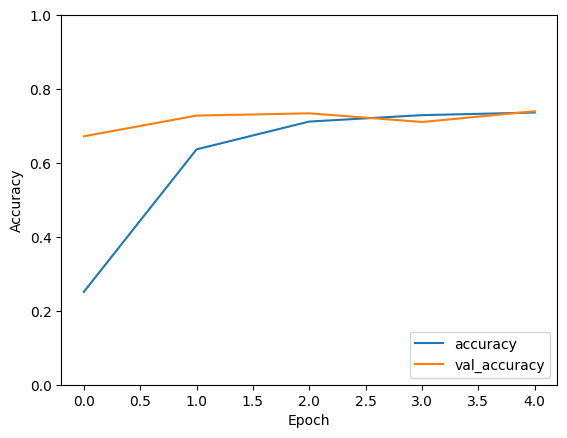

In [38]:
# Train model
history = model.fit(X_train_re, y_train_re, epochs=5, batch_size=32, validation_data=(X_val_re, y_val_re))

# plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [40]:
# evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

69/69 - 1s - loss: 0.3455 - accuracy: 0.7252 - 552ms/epoch - 8ms/step
0.7252047061920166
